<center><h2>Deep Learning for Image Classification: Aakash Patil</h2></center> 

## 1. Problem Overview and Objective
This notebook explores the classic image classification problem: distinguishing between images of cats and dogs. We leverage deep learning models, data augmentation, and transfer learning to build an efficient and accurate classifier. The final goal is to generate predictions on a test set and achieve a log loss lower than existing benchmarks (MSBA standard).

---

## 2. Data Loading and Labeling
The data is sourced from a Kaggle competition. The zipped files `train.zip` and `test.zip` are extracted, and image file names are parsed to assign binary labels: 0 for cats and 1 for dogs. These labels, along with filenames, are stored in a DataFrame.

> Why? Using file names for labeling avoids directory-level manual labeling and keeps the pipeline clean. A DataFrame makes the data easy to split, shuffle, and track across training/validation.

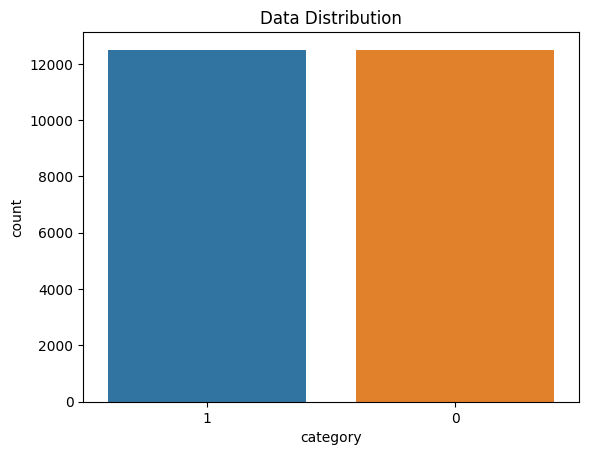

In [1]:
import os
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnetv2_preprocess
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers

# Set paths
data_dir = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/'
train_zip_path = os.path.join(data_dir, 'train.zip')
test_zip_path = os.path.join(data_dir, 'test.zip')

# Unzip the files
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('data/train')

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('data/test')

# Define helper functions to create dataframe with labels
def gen_label(directory):
    label = []
    for file in os.listdir(directory):
        if file.startswith('dog'):
            label.append('1')
        elif file.startswith('cat'):
            label.append('0')
    return label

def get_path(directory):
    path = []
    for file in os.listdir(directory):
        path.append(file)
    return path

# Build dataframe
image_dir = 'data/train/train'
train_x = get_path(image_dir)
train_y = gen_label(image_dir)
df = pd.DataFrame({'filename': train_x, 'category': train_y})

# Visualize class distribution
sns.countplot(x='category', data=df).set_title("Data Distribution")
plt.show()



## 3. Data Distribution and Visualization
Before training, above we visualized the class distribution using a seaborn countplot. This ensures that the dataset is balanced, and we avoid class imbalance bias.

> Why? Any skew in class distribution could lead the model to become biased toward the majority class. Visualization confirms we’re good to go.

---

## 4. Train/Validation Split
We split the labeled data into a training set (75%) and a validation set (25%) using `train_test_split` with stratification to preserve class proportions.

> Why? The validation set helps us assess generalization and tune hyperparameters without leaking test information.

In [2]:
# Split into train/validation sets
train_df, valid_df = train_test_split(df, test_size=0.25, random_state=42, stratify=df['category'])
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print(f"Training set: {train_df.shape[0]} samples")
print(f"Validation set: {valid_df.shape[0]} samples")

# Image size and batch size settings
img_size = 150
batch_size = 32

Training set: 18750 samples
Validation set: 6250 samples


## 5. Image Generators and Preprocessing
Using `ImageDataGenerator`, we apply standard augmentations like rotation, zoom, shift, and horizontal flip. These are applied only on the training set. Different preprocessing functions are used depending on the model type (ResNet, VGG, etc.).

> Why? Augmentation simulates new data, helping the model generalize better and preventing overfitting. Model-specific preprocessing aligns input with how pretrained networks were trained.


In [3]:
# Generator functions for different model types
def generate_train_batch(model='others'):
    if model == 'resnet':
        print('Using ResNet-specific preprocessing')
        train_datagen = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest',
            width_shift_range=0.1,
            height_shift_range=0.1,
            preprocessing_function=resnet_preprocess)
    else:
        train_datagen = ImageDataGenerator(
            rotation_range=10,
            rescale=1./255,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest',
            width_shift_range=0.1,
            height_shift_range=0.1)

    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        directory=image_dir,
        x_col='filename',
        y_col='category',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

    return train_gen

def generate_valid_batch(model='others'):
    if model == 'resnet':
        print('Using ResNet-specific validation preprocessing')
        valid_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
    else:
        valid_datagen = ImageDataGenerator(rescale=1./255)

    valid_gen = valid_datagen.flow_from_dataframe(
        valid_df,
        directory=image_dir,
        x_col='filename',
        y_col='category',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')

    return valid_gen



## 6. Data Augmentation Visualization
We display 9 augmented versions of a random training image to visually confirm the effect of augmentations.

> Why? Sanity-checking augmentations ensures we don’t apply destructive or unrealistic transformations.



Found 1 validated image filenames belonging to 1 classes.


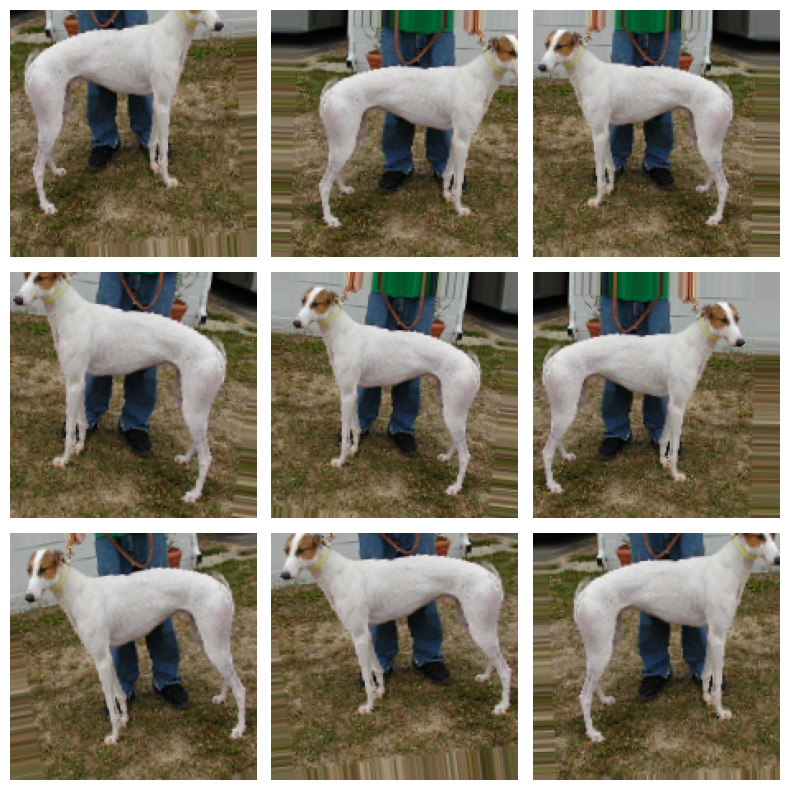

In [4]:
# Visualize data augmentation
visual_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

visualise_df = train_df.sample(n=1).reset_index(drop=True)
visualisation_generator = visual_datagen.flow_from_dataframe(
    visualise_df,
    directory=image_dir,
    x_col='filename',
    y_col='category',
    target_size=(img_size, img_size),
    batch_size=1)

plt.figure(figsize=(8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in visualisation_generator:
        image = X_batch[0]
        plt.imshow(image)
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

## 7. Baseline Model - Simple CNN
We first implement a custom CNN with three convolutional layers. This model provides a performance baseline and helps us validate the data pipeline.

> Output: The baseline model achieves ~85% validation accuracy.

> Why? Always start simple. This gives us a benchmark and highlights the limitations of training from scratch.

In [5]:
# Build a simple baseline CNN model
def build_simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])
    return model

# Generate data
train_gen = generate_train_batch('others')
valid_gen = generate_valid_batch('others')

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


In [21]:
# Build and train model
baseline_model = build_simple_cnn()
baseline_model.summary()

history = baseline_model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


586/586 ━━━━━━━━━━━━━━━━━━━━ 116s 190ms/step - accuracy: 0.5917 - loss: 0.6604 - val_accuracy: 0.7101 - val_loss: 0.5632
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 110s 185ms/step - accuracy: 0.7201 - loss: 0.5488 - val_accuracy: 0.7678 - val_loss: 0.4845
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 109s 185ms/step - accuracy: 0.7555 - loss: 0.5030 - val_accuracy: 0.7918 - val_loss: 0.4480
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 112s 189ms/step - accuracy: 0.7787 - loss: 0.4703 - val_accuracy: 0.8034 - val_loss: 0.4267
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 112s 189ms/step - accuracy: 0.7989 - loss: 0.4450 - val_accuracy: 0.8059 - val_loss: 0.4268
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 112s 189ms/step - accuracy: 0.8029 - loss: 0.4279 - val_accuracy: 0.8195 - val_loss: 0.3895
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 111s 187ms/step - accuracy: 0.8140 - loss: 0.4117 - val_accuracy: 0.8347 - val_loss: 0.3777
Epoch 8/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 111s 187ms/step - accuracy: 0.8175 - loss: 0.40

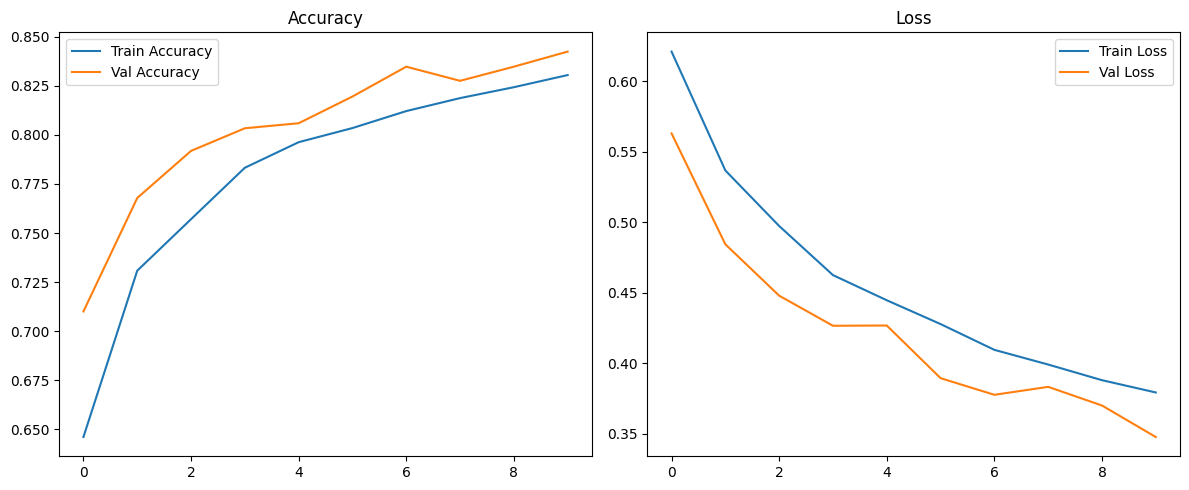

In [22]:

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

## 8. Transfer Learning Models: ResNet50 and VGG16
We implement two popular transfer learning architectures:
- **ResNet50**: Uses residual connections, great for deeper networks.
- **VGG16**: Known for simplicity and effectiveness.

Both models are fine-tuned with a custom dense head and trained on our dataset.

> Output: ResNet50 outperforms VGG16 on validation accuracy and loss.

> Why? Transfer learning leverages pretrained image features. This speeds up convergence and improves generalization, especially on small datasets.

### 8.1 ResNet50

In [23]:
# Build and train ResNet50 model with transfer learning
def build_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Generate data for ResNet model
train_gen_resnet = generate_train_batch('resnet')
valid_gen_resnet = generate_valid_batch('resnet')

resnet_model = build_resnet_model()
resnet_model.summary()

resnet_history = resnet_model.fit(
    train_gen_resnet,
    epochs=10,
    validation_data=valid_gen_resnet
)

Using ResNet-specific preprocessing
Found 18750 validated image filenames belonging to 2 classes.
Using ResNet-specific validation preprocessing
Found 6250 validated image filenames belonging to 2 classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


586/586 ━━━━━━━━━━━━━━━━━━━━ 140s 212ms/step - accuracy: 0.9071 - loss: 0.2119 - val_accuracy: 0.9712 - val_loss: 0.0746
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 115s 195ms/step - accuracy: 0.9669 - loss: 0.0817 - val_accuracy: 0.9738 - val_loss: 0.0692
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 114s 192ms/step - accuracy: 0.9725 - loss: 0.0722 - val_accuracy: 0.9726 - val_loss: 0.0727
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 114s 192ms/step - accuracy: 0.9737 - loss: 0.0696 - val_accuracy: 0.9741 - val_loss: 0.0639
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 113s 192ms/step - accuracy: 0.9762 - loss: 0.0642 - val_accuracy: 0.9738 - val_loss: 0.0668
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 113s 190ms/step - accuracy: 0.9781 - loss: 0.0583 - val_accuracy: 0.9770 - val_loss: 0.0581
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 112s 189ms/step - accuracy: 0.9803 - loss: 0.0560 - val_accuracy: 0.9760 - val_loss: 0.0589
Epoch 8/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 110s 186ms/step - accuracy: 0.9796 - loss: 0.05

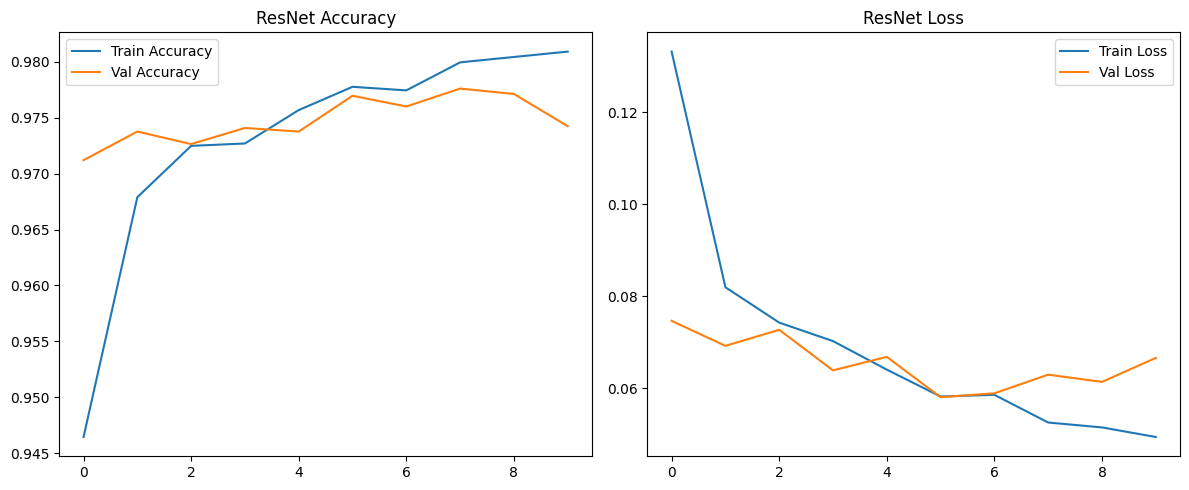

In [24]:
# Plot ResNet training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('ResNet Accuracy')

plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('ResNet Loss')

plt.tight_layout()
plt.show()

> Very promising with it's high validation accuracy

### 8.2 VGG16

In [25]:
# Build and train VGG16 model with transfer learning
def build_vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Generate data for VGG model
train_gen_vgg = generate_train_batch('others')  # VGG can use standard rescaling
valid_gen_vgg = generate_valid_batch('others')

vgg_model = build_vgg_model()
vgg_model.summary()

vgg_history = vgg_model.fit(
    train_gen_vgg,
    epochs=10,
    validation_data=valid_gen_vgg
)


Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


586/586 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - accuracy: 0.6732 - loss: 0.5923 - val_accuracy: 0.8536 - val_loss: 0.3659
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 110s 185ms/step - accuracy: 0.8342 - loss: 0.3868 - val_accuracy: 0.8720 - val_loss: 0.3174
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 110s 185ms/step - accuracy: 0.8486 - loss: 0.3462 - val_accuracy: 0.8846 - val_loss: 0.2822
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 110s 186ms/step - accuracy: 0.8601 - loss: 0.3160 - val_accuracy: 0.8864 - val_loss: 0.2700
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 111s 188ms/step - accuracy: 0.8661 - loss: 0.3086 - val_accuracy: 0.8934 - val_loss: 0.2593
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 110s 186ms/step - accuracy: 0.8740 - loss: 0.2959 - val_accuracy: 0.8936 - val_loss: 0.2583
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 110s 186ms/step - accuracy: 0.8720 - loss: 0.2971 - val_accuracy: 0.8963 - val_loss: 0.2500
Epoch 8/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 111s 187ms/step - accuracy: 0.8797 - loss: 0.28

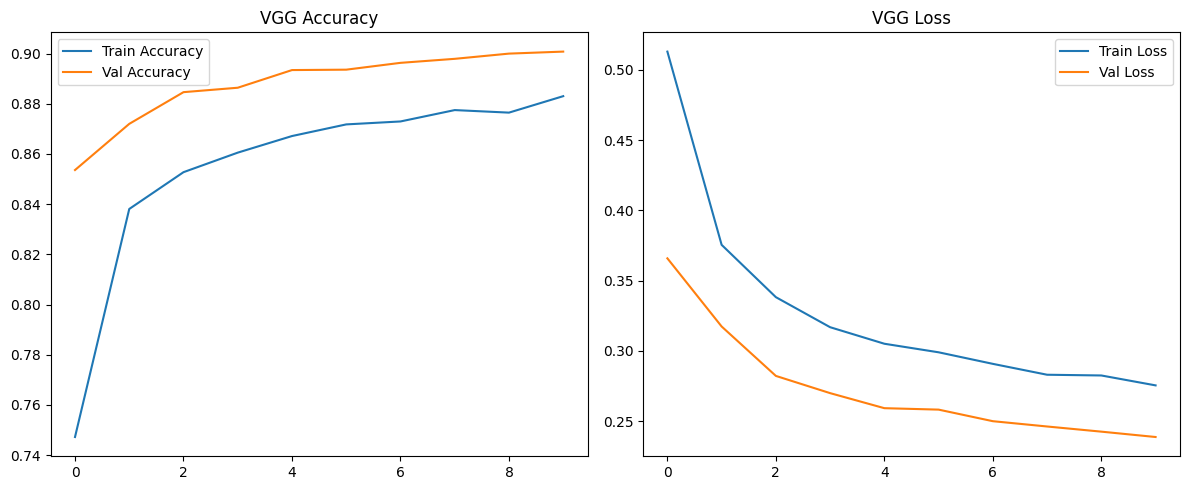

In [26]:

# Plot VGG training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('VGG Accuracy')

plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('VGG Loss')

plt.tight_layout()
plt.show()


> Better than simple CNN, but ResNet still outperforms VGG16.

## 9. Model Comparison
We visually compare validation accuracy and loss across Simple CNN, ResNet50, and VGG16.

> Decision: ResNet50 is selected as the best model for further optimization.

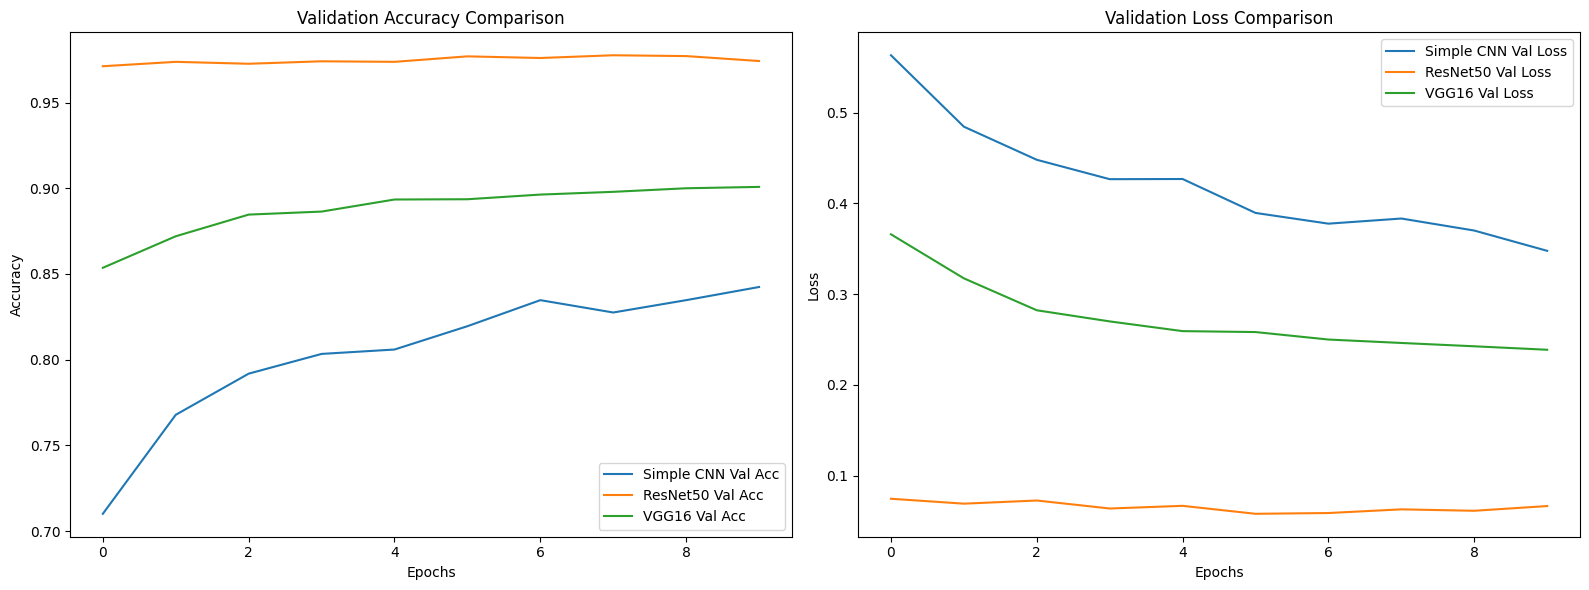

In [27]:
# Compare all three models: Simple CNN, ResNet50, and VGG16

def compare_histories(histories, labels):
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['val_accuracy'], label=f'{label} Val Acc')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['val_loss'], label=f'{label} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Compare models visually
compare_histories(
    histories=[history, resnet_history, vgg_history],
    labels=['Simple CNN', 'ResNet50', 'VGG16']
)


## 10. Full Training on ResNet50
We retrain ResNet50 on the full training set (train + val combined), using moderate augmentation and a lower learning rate. All layers are unfrozen for fine-tuning.

> Output: The model achieves over 98% training accuracy with very low loss.

> Why? With confidence in our model architecture, we maximize its learning on the full dataset for final test predictions.

In [28]:
# Re-train ResNet50 on full training dataset with tuned hyperparameters

def generate_full_train_batch():
    full_datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        width_shift_range=0.1,
        height_shift_range=0.1,
        preprocessing_function=resnet_preprocess
    )

    full_gen = full_datagen.flow_from_dataframe(
        df,
        directory=image_dir,
        x_col='filename',
        y_col='category',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary')
    return full_gen

# Regenerate full training set
full_train_gen = generate_full_train_batch()

# Build new ResNet50 model
def build_resnet_finetuned():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Train fine-tuned model on full dataset
final_resnet_model = build_resnet_finetuned()
final_resnet_model.summary()

final_history = final_resnet_model.fit(
    full_train_gen,
    epochs=5  # can increase to 10–15 if training time permits
)


Found 25000 validated image filenames belonging to 2 classes.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 24,059,393 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 240s 212ms/step - accuracy: 0.8341 - loss: 0.3471
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 183ms/step - accuracy: 0.9680 - loss: 0.0826
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 147s 186ms/step - accuracy: 0.9781 - loss: 0.0571
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 181ms/step - accuracy: 0.9855 - loss: 0.0392
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 180ms/step - accuracy: 0.9892 - loss: 0.0317


In [29]:
# Prepare test set
final_test_dir = 'data/test/test'
test_filenames = sorted(os.listdir(final_test_dir), key=lambda x: int(x.split('.')[0]))

test_images = []
ids = []

for fname in test_filenames:
    img_path = os.path.join(final_test_dir, fname)
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = resnet_preprocess(img_array)
    test_images.append(img_array)
    ids.append(int(fname.split('.')[0]))

X_test = np.array(test_images)

# Generate predictions
predictions = final_resnet_model.predict(X_test, verbose=1)
predictions = predictions.flatten()

submission_df = pd.DataFrame({'id': ids, 'label': predictions})
submission_df = submission_df.sort_values('id')
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created!")


391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step
Submission file 'submission.csv' created!


### (NOT THE FINAL SCORE) Predicting on test set and checking predictions on Kaggle



> We find our ResNet model performs well, giving a log loss of **0.10773**

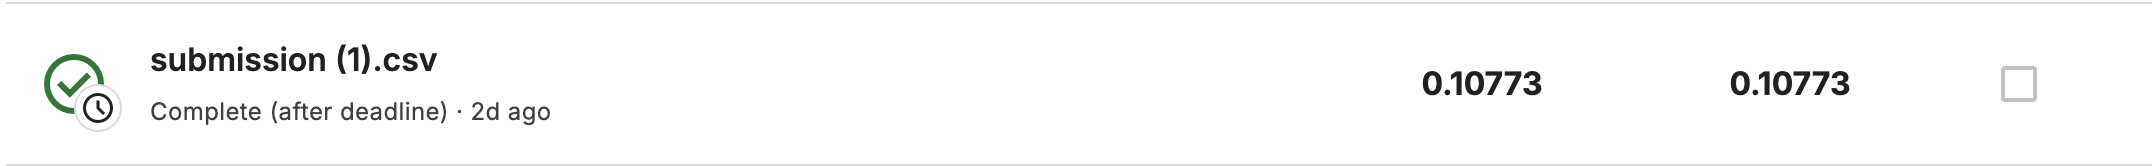

## 11. Advanced Optimization with ResNet50V2
We further explore model performance using **ResNet50V2**, an improved variant:
- Input resolution is increased to 224x224 (native size for ResNet).
- Deeper augmentations are added.
- Batch normalization, dropout, and layer freezing strategies are introduced.
- Longer training with callbacks (`ReduceLROnPlateau`, `EarlyStopping`) ensures optimal performance.

> Output: ResNet50V2 with enhancements achieves top training accuracy and is selected for final prediction.

> Why? ResNet50V2 improves feature flow through the network and handles deeper representations more efficiently.

In [ ]:
# Enhanced ResNet50V2 with fine-tuning strategy and more epochs
# Set high resolution and training settings
img_size_v2 = 224
batch_size_v2 = 32
epochs_v2 = 20

# Updated data generator with more augmentations and normalization
train_datagen_v2 = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=resnetv2_preprocess
)

train_gen_v2 = train_datagen_v2.flow_from_dataframe(
    df,
    directory=image_dir,
    x_col='filename',
    y_col='category',
    target_size=(img_size_v2, img_size_v2),
    batch_size=batch_size_v2,
    class_mode='binary'
)

# Callbacks to optimize training
checkpoint = ModelCheckpoint('best_resnet50v2.keras', monitor='loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)

# Build enhanced ResNet50V2 model
base_model_v2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_size_v2, img_size_v2, 3))

# Freeze first few layers to retain pretrained features
for layer in base_model_v2.layers[:100]:
    layer.trainable = False
for layer in base_model_v2.layers[100:]:
    layer.trainable = True

x = base_model_v2.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)

resnetv2_model_enhanced = Model(inputs=base_model_v2.input, outputs=output)
resnetv2_model_enhanced.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Train the enhanced model
resnetv2_enhanced_history = resnetv2_model_enhanced.fit(
    train_gen_v2,
    epochs=epochs_v2,
    callbacks=[checkpoint, reduce_lr, early_stop],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7561 - loss: 0.5066
Epoch 1: loss improved from inf to 0.32356, saving model to best_resnet50v2.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 311s 347ms/step - accuracy: 0.7562 - loss: 0.5064 - learning_rate: 1.0000e-05
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9377 - loss: 0.1556
Epoch 2: loss improved from 0.32356 to 0.13579, saving model to best_resnet50v2.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 263s 333ms/step - accuracy: 0.9377 - loss: 0.1556 - learning_rate: 1.0000e-05
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9581 - loss: 0.1056
Epoch 3: loss improved from 0.13579 to 0.10104, saving model to best_resnet50v2.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 264s 334ms/step - accuracy: 0.9581 - loss: 0.1056 - learning_rate: 1.0000e-05
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9654 - loss: 0.0902
Epoch 4: loss improved from 0.10104 to 0.08878, saving model to best_resnet50v2.kera

## 12. Efficient Prediction on Test Set
To avoid RAM issues, we use a custom `Sequence` generator to load and predict on test images in batches. The predictions are saved in `submission_resnet50v2_enhanced.csv`.

> Why? Loading all test images into memory at once is inefficient. Sequences ensure scalability and performance.

In [12]:
# Memory-efficient prediction and submission for enhanced ResNet50V2

class TestSequenceV2(Sequence):
    def __init__(self, file_list, directory, batch_size, target_size):
        self.file_list = file_list
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.file_list) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_files = self.file_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []

        for fname in batch_files:
            path = os.path.join(self.directory, fname)
            img = image.load_img(path, target_size=self.target_size)
            img_array = image.img_to_array(img)
            img_array = resnetv2_preprocess(img_array)
            batch_images.append(img_array)

        return np.array(batch_images)

# Prepare test set
final_test_dir = 'data/test/test'
test_filenames_v2 = sorted(os.listdir(final_test_dir), key=lambda x: int(x.split('.')[0]))
test_ids_v2 = [int(x.split('.')[0]) for x in test_filenames_v2]

# Create sequence
test_sequence_v2 = TestSequenceV2(
    file_list=test_filenames_v2,
    directory=final_test_dir,
    batch_size=batch_size_v2,
    target_size=(img_size_v2, img_size_v2)
)

# Predict
predictions_v2 = resnetv2_model_enhanced.predict(test_sequence_v2, verbose=1).flatten()

# Submission file
submission_df_v2 = pd.DataFrame({'id': test_ids_v2, 'label': predictions_v2})
submission_df_v2 = submission_df_v2.sort_values('id')
submission_df_v2.to_csv('submission_resnet50v2_enhanced.csv', index=False)
print("Enhanced ResNet50V2 test prediction complete. Submission saved as 'submission_resnet50v2_enhanced.csv'")

391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step
Enhanced ResNet50V2 test prediction complete. Submission saved as 'submission_resnet50v2_enhanced.csv'


## 13. Final Score

After submitting this highly refined ResNet50V2 model - we are able to achieve a log loss of **0.06596**

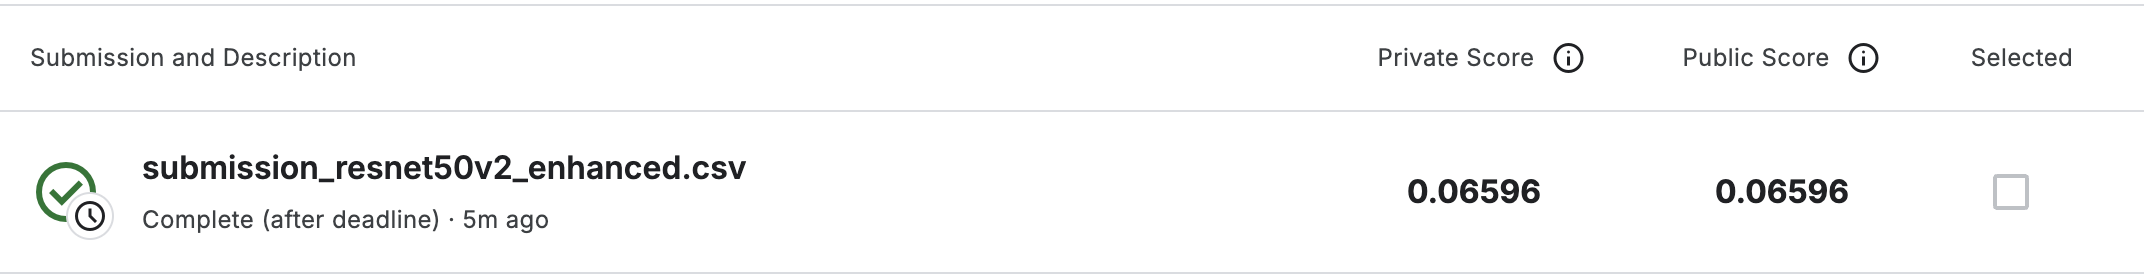

## 14. Conclusion
Through a structured exploration — from baseline CNN to fine-tuned ResNet50V2 — we arrive at a high-performing image classifier. The use of preprocessing, augmentation, transfer learning, and memory-efficient prediction ensures a robust solution.